In [1]:
import torch
import torch.nn as nn
import torchvision

import numpy as np
from PIL import Image
from tqdm import tqdm
from livelossplot import PlotLosses

from sklearn.metrics import classification_report, f1_score
%pylab inline
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

Populating the interactive namespace from numpy and matplotlib


In [2]:
# Change path to root folder of the data provided
path_to_data = 'flowers/'

# a dataset abstraction that figures out classes on it's own based on what folder the images were in
_data = torchvision.datasets.DatasetFolder(
    path_to_data,                                  # root path, it'll get paths to actual images on it's own
    Image.open,                                    # pillow open image function to load data from given path
    ['jpg', 'JPG'],                                # list of extensions for images in dataset
    transform = torchvision.transforms.Compose([   # a pipeline of transformations to apply on the read image
        torchvision.transforms.Resize((224, 224)),
        torchvision.transforms.ToTensor(),
        torchvision.transforms.Normalize(mean=[0.485, 0.456, 0.406], # the documentation said that alexnet was modelled with
                                 std=[0.229, 0.224, 0.225])          # images using this normalisation parameters
    ]),
)

In [3]:
# some unfortunate ugly code to split the data randomly into training and testing
split_at = 0.8
train, test = torch.utils.data.random_split(
    _data,
    [int(split_at*(len(_data))), len(_data) - int(split_at*(len(_data)))]
)

In [4]:
batch_size = 96
# defining loaders for the train and test datasets
train_batches = torch.utils.data.DataLoader(
    train,                                       # dataset 
    batch_size=batch_size,                       # size of batches to load
    shuffle=True,
    num_workers=8,                               # no of workers
    pin_memory=True                              # Host to GPU copies are much faster when they originate from pinned (page-locked) memory. CPU tensors and storages expose a pin_memory() method, that returns a copy of the object, with data put in a pinned region.
) 

test_batches = torch.utils.data.DataLoader(
    test,                                       # dataset 
    batch_size=batch_size,                      # size of batches to load
    shuffle=True,
    num_workers=8,                               # no of workers
    pin_memory=True                              # Host to GPU copies are much faster when they originate from pinned (page-locked) memory. CPU tensors and storages expose a pin_memory() method, that returns a copy of the object, with data put in a pinned region.
) 

In [5]:
# it'll download alexnet weights on it's own
squeezenet = torchvision.models.squeezenet1_1(
    pretrained=True,
)
squeezenet

c:\users\dhruv\appdata\local\programs\python\python36\lib\site-packages\torchvision\models\squeezenet.py:94: UserWarning: nn.init.kaiming_uniform is now deprecated in favor of nn.init.kaiming_uniform_.
  init.kaiming_uniform(m.weight.data)
c:\users\dhruv\appdata\local\programs\python\python36\lib\site-packages\torchvision\models\squeezenet.py:92: UserWarning: nn.init.normal is now deprecated in favor of nn.init.normal_.
  init.normal(m.weight.data, mean=0.0, std=0.01)


SqueezeNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(2, 2))
    (1): ReLU(inplace)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
    (3): Fire(
      (squeeze): Conv2d(64, 16, kernel_size=(1, 1), stride=(1, 1))
      (squeeze_activation): ReLU(inplace)
      (expand1x1): Conv2d(16, 64, kernel_size=(1, 1), stride=(1, 1))
      (expand1x1_activation): ReLU(inplace)
      (expand3x3): Conv2d(16, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (expand3x3_activation): ReLU(inplace)
    )
    (4): Fire(
      (squeeze): Conv2d(128, 16, kernel_size=(1, 1), stride=(1, 1))
      (squeeze_activation): ReLU(inplace)
      (expand1x1): Conv2d(16, 64, kernel_size=(1, 1), stride=(1, 1))
      (expand1x1_activation): ReLU(inplace)
      (expand3x3): Conv2d(16, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (expand3x3_activation): ReLU(inplace)
    )
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0

In [6]:
# get list of classes from names of folders inside the path to data
import os
label_names = os.listdir(path_to_data)

# set num of classes, so as to set the output dimensions
squeezenet.num_classes = len(label_names)

In [7]:
# create new instances of the same layers, to get rid of the pretrained weights in the classification layers
# we want to learn our own
layers = [
#     nn.BatchNorm2d(512),
    nn.Dropout(0.5),
    nn.Conv2d(512, squeezenet.num_classes, kernel_size=(1, 1), stride=(1, 1)),
#     nn.BatchNorm2d(squeezenet.num_classes),
    nn.ReLU(inplace=True),
#     nn.Dropout(0.5),
    nn.AvgPool2d(kernel_size=13, stride=1, padding=0)
]

# change the classification layers to the untrained ones we just defined
# I am not sure why this syntax works, I found it in a medium article
squeezenet.classifier = nn.Sequential(*layers)
# but it gets the job done
squeezenet.classifier

Sequential(
  (0): Dropout(p=0.5)
  (1): Conv2d(512, 5, kernel_size=(1, 1), stride=(1, 1))
  (2): ReLU(inplace)
  (3): AvgPool2d(kernel_size=13, stride=1, padding=0)
)

In [8]:
loss = nn.CrossEntropyLoss()                # loss function
# it's softmax followed by Negative Log Likelihood loss

# defining an optimizer
optimizer = torch.optim.Adam(
    squeezenet.parameters(),   
    lr=1e-4,
    amsgrad = True
)

squeezenet.to(device)           # load up all the weights to cuda device memory, if available
live_losses = PlotLosses()   # a tool for drawing plots

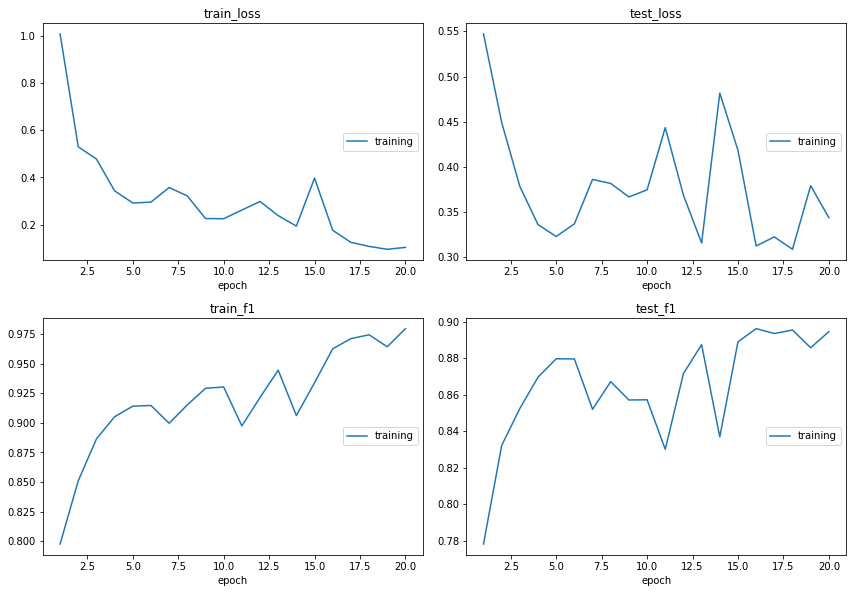

In [9]:
# training
for epoch in range(20):
    squeezenet.train()  # set model to train mode. not sure what that does, probably some optimisations
    
    train_errors = []  
    test_errors = []
    for i, batch in enumerate(tqdm(train_batches)):
        X, Y = batch
        pred = squeezenet(X.to(device))
        
        optimizer.zero_grad()               # reset the gradients
        error = loss(pred, Y.to(device))    # get loss
        error.backward()                    # propogate loss backwards
        optimizer.step()                    # update params
        
        train_errors.append(error.data.item())
        
    
    squeezenet.eval()  # set model to evaluate mode. not sure what that does exactly
    
    # some code to calculate f1 score for the test set
    predict = lambda x: torch.argmax(x, dim=1).cpu().numpy()
    test_predictions = []
    test_actual = []
    for batch in test_batches:
        x, y = batch
        pred = squeezenet(x.to(device))
        test_predictions.append(predict(pred))
        test_errors.append(loss(pred, y.to(device)).data.item())    # get loss
        test_actual.append(np.array(y))
    
    train_predictions = []
    train_actual = []
    for batch in train_batches:
        x, y = batch
        pred = squeezenet(x.to(device))
        train_predictions.append(predict(pred))
        train_actual.append(np.array(y))

    # log data to be plotted later
    live_losses.update({
        'train_loss': np.mean(np.array(train_errors)),
        'test_loss': np.mean(np.array(test_errors)),
        'train_f1': f1_score(np.concatenate(train_actual), np.concatenate(train_predictions), average='weighted'),
        'test_f1': f1_score(np.concatenate(test_actual), np.concatenate(test_predictions), average='weighted'),
    })
    live_losses.draw() # plot loss curves    




In [10]:
# # some code to calculate f1 score for the test set
# predict = lambda x: torch.argmax(x, dim=1).cpu().numpy()
# test_predictions = []
# test_actual = []
# for batch in test_batches:
#     x, y = batch
#     pred = squeezenet(x.to(device))
#     test_predictions.append(predict(pred))
#     test_errors.append(loss(pred, y.to(device)).data.item())    # get loss
#     test_actual.append(np.array(y))
    
# train_predictions = []
# train_actual = []
# for batch in train_batches:
#     x, y = batch
#     pred = squeezenet(x.to(device))
#     train_predictions.append(predict(pred))
#     train_actual.append(np.array(y))

print(classification_report(
    np.concatenate(train_actual),
    np.concatenate(train_predictions),
    labels = range(len(label_names)),
    target_names = label_names
))


print(classification_report(
    np.concatenate(test_actual),
    np.concatenate(test_predictions),
    labels = range(len(label_names)),
    target_names = label_names
))

              precision    recall  f1-score   support

       daisy       0.98      0.99      0.98       609
   dandelion       1.00      0.97      0.98       843
        rose       0.99      0.96      0.98       644
   sunflower       0.98      0.99      0.98       591
       tulip       0.96      0.99      0.97       771

   micro avg       0.98      0.98      0.98      3458
   macro avg       0.98      0.98      0.98      3458
weighted avg       0.98      0.98      0.98      3458

              precision    recall  f1-score   support

       daisy       0.90      0.93      0.91       160
   dandelion       0.95      0.88      0.92       209
        rose       0.87      0.82      0.85       140
   sunflower       0.87      0.94      0.91       143
       tulip       0.87      0.90      0.88       213

   micro avg       0.89      0.89      0.89       865
   macro avg       0.89      0.89      0.89       865
weighted avg       0.90      0.89      0.89       865



In [11]:
batch = next(iter(train_batches))

In [12]:
# x = batch[0]
# y = batch[1]
# alexnet(x)
torch.cuda.memory_allocated()

61505536

In [13]:
squeezenet.to("cpu")

SqueezeNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(2, 2))
    (1): ReLU(inplace)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
    (3): Fire(
      (squeeze): Conv2d(64, 16, kernel_size=(1, 1), stride=(1, 1))
      (squeeze_activation): ReLU(inplace)
      (expand1x1): Conv2d(16, 64, kernel_size=(1, 1), stride=(1, 1))
      (expand1x1_activation): ReLU(inplace)
      (expand3x3): Conv2d(16, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (expand3x3_activation): ReLU(inplace)
    )
    (4): Fire(
      (squeeze): Conv2d(128, 16, kernel_size=(1, 1), stride=(1, 1))
      (squeeze_activation): ReLU(inplace)
      (expand1x1): Conv2d(16, 64, kernel_size=(1, 1), stride=(1, 1))
      (expand1x1_activation): ReLU(inplace)
      (expand3x3): Conv2d(16, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (expand3x3_activation): ReLU(inplace)
    )
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0